# 10장. 데이터 다루기(Data Handling)

###   

## 10.0 시작에 앞서..
: 이전 챕터에서 활용되었던 함수 및 패키지, 모듈 호출

In [83]:
import math, random
from matplotlib import pyplot as plt
from collections import Counter

def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    """find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    
    low_z, low_p = -10.0, 0            # normal_cdf(-10) is (very close to) 0
    hi_z,  hi_p  =  10.0, 1            # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the cdf's value there
        if mid_p < p:
            # midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p
        else:
            break

    return mid_z

def normal_cdf(x,mu=0,sigma=1):
    return (1 + math.erf((x - mu) / math.sqrt(2)/sigma)) /2 

###   

## 10.1 데이터 검색하기

###   


### 10.1.1 1차원 데이터 탐색하기
: 우선 1차원 데이터가 주어졌을 땐 가장 먼저 요약 통계치(Summary Statistics)를 계산해봐야한다.

- 우선 히스토그램을 만들어보고자 한다.

In [84]:


def bucketize(point, bucket_size):
    """각 데이터를 bucket_size의 배수에 해당하는 구간에 위치시킨다."""
    """분위 값으로 해당 값을 나눠준 뒤 올림을 해준 뒤 분위값을 곱해서 값들을 동일하게 맞춰준다."""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points, bucket_size):
    """구간을 생성하고 각 가군 내 데이터 개수를 계산해 준다."""
    """각 분위마다 몇 개의 값이 실제하는 지 계산한다."""
    return Counter(bucketize(point,bucket_size) for point in points )

def plot_histogram(points, bucket_size, title=""):
    histogram = make_histogram(points,bucket_size)
    plt.bar(histogram.keys(),histogram.values(),width=bucket_size)
    plt.title(title)
    plt.show()

In [85]:
random.seed(0)

# -100과 100 사이의 균등분포
uniform = [200 * random.random() - 100 for _ in range(10000)]

# 평균이 0이고 표준편차가 57인 정규분포
normal = [57 * inverse_normal_cdf(random.random()) for _ in range(10000) ]

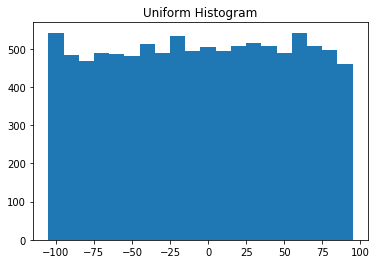

In [86]:
plot_histogram(uniform, 10, "Uniform Histogram")

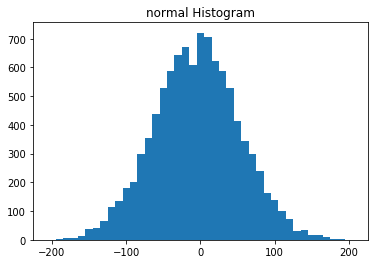

In [87]:
plot_histogram(normal, 10, "normal Histogram")

### 10.1.2 2차원 데이터
: 추가적으로 하루평균 사이트에서 보내는 시간 뿐 아니라 데이터 과학 경력 또한 주어졌을 경우.


In [88]:
def random_normal():
    """표준 정규분포를 따르는 임의의 데이터를 반환"""
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(10000)]
ys1 = [ x + random_normal()/2 for x in xs]
ys2 = [- x + random_normal()/2 for x in xs]

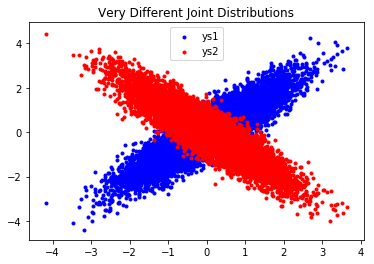

In [89]:
plt.scatter(xs,ys1,marker='.',color ='blue',label='ys1')
plt.scatter(xs,ys2,marker='.',color ='red',label='ys2')
plt.legend(loc=9)
plt.title("Very Different Joint Distributions")
plt.show()

In [90]:
print (correlation(xs,ys1))
print (correlation(xs,ys2))

0.8925806189227748
-0.8956130066187867


In [91]:
def correlation(x,y):
    stdev_x = standard_deviation(x)
    stdev_y = standard_deviation(y)
    if stdev_x > 0 and stdev_y > 0:
        return covariance(x,y) / stdev_x / stdev_y
    else:
        # 편차가 존재하지 않는다면 상관관계는 0
        return 0
    
def standard_deviation(x):
    return math.sqrt(variance(x))

def variance(x):
    n = len(x)
    deviations = de_mean(x)
    return sum_of_squares(deviations) / (n - 1)

def de_mean(x):
    x_bar = mean(x)
    return [x_i - x_bar for x_i in x]

def mean(x):
    return sum(x) / len(x)

def sum_of_squares(v):
    return dot(v,v)

def dot(v,w):
    return sum(v_i * w_i for v_i, w_i in zip(v,w))

def covariance(x,y):
    n = len(x)
    return dot(de_mean(x),de_mean(y)) / (n - 1)

def shape(A):
    num_rows = len(A)
    try:
        num_columns = len(A[0]) if A else 0
    except:
        num_columns = 0
    return num_rows, num_columns

def get_column(A,j):
    return [A_i[j] for A_i in A]

### 10.1.3 다차원 데이터
:다차원 데이터의 경우 각 차원이 서로 어떻게 연관되어 있는지 살펴볼 수 있다.

In [92]:
def correlation_matrix(data):
    """(i,j)번째 항목이 i번째 차원과  j번째 차원의 상관관계를 나타내는 num_columns x num_columns 행렬 반환"""
    _, num_columns = shape(data)
    
    def matrix_entry(i,j):
        return correlation(get_column(data,i), get_column(data,j))
    
    return make_matrix(num_columns, num_columns,matrix_entry)

import matplotlib.pyplot as plt

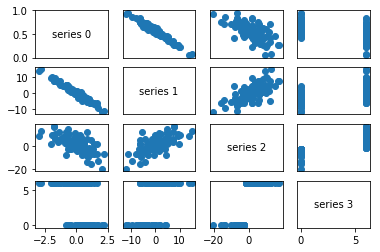

In [93]:
# first, generate some random data

num_points = 100

def random_row():
    row = [None, None, None, None]
    row[0] = random_normal()
    row[1] = -5 * row[0] + random_normal()
    row[2] = row[0] + row[1] + 5 * random_normal()
    row[3] = 6 if row[2] > -2 else 0
    return row
random.seed(0)
data = [random_row()
        for _ in range(num_points)]



_,num_columns = shape(data)

fig, ax = plt.subplots(num_columns,num_columns)

for i in range(num_columns):
    for j in range(num_columns):
        
        # x축은 j번째 열을, y축은 i번째 행을 나타내는 산포도
        if i != j: ax[i][j].scatter(get_column(data,j),get_column(data,i))
        
        # 만약 i == j, series 라는 제목 출력
        else: ax[i][j].annotate("series "+str(i), (0.5,0.5),
                               xycoords='axes fraction',
                               ha='center',va='center')
        #왼쪽과 밑에 위치한 차트에만 축 레이블 명시
        if i < num_columns -1 : ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)
            
#밑에서 가장 오른쪽 그리고 ㅇ왼쪽에서
#가장 위에 위치한 차트 안에는 문자열만 있기 때문에
# 축 레이블을 고정

ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_xlim(ax[0][1].get_ylim())

plt.show()

## 10.2 정제하고 합치기

In [94]:
#기존에 형변환했던 방법
#closing_price = float(row[2])

In [95]:

def  parse_row(input_row, parsers):
    """파서 list(None이 포함될 수도 있다)가 주어지면 각 input_row의 항목에 적절한 파서를 적용"""
    return [parser(value) if parser is not None else value for value, parser in zip(input_row, parsers)]

def parse_rows_with(reader, parsers):
    """각 열에 파서를 적용하기 위해 reader를 치환"""
    for row in reader:
        yield parse_row(row, parsers)

def try_or_none(f):
    """f가 하나의 입력값을 받는다고 가정하고, 오류가 발생하면 f는 None을 반환해주는 함수로 치환하자"""
    def f_or_none(x):
        try: return f(x)
        except: return None
    return f_or_none

def parse_row(input_row, parsers):
    return [try_or_none(parser)(value) if parser is not None else value
            for value, parser in zip(input_row, parsers)]

In [96]:
import dateutil.parser, csv

data  =  []

with  open("./data/comma_delimited_stock_prices.csv", "r", encoding='utf8', newline='') as f:
    reader = csv.reader(f)
    for line in parse_rows_with(reader, [dateutil.parser.parse, None, float]):
        data.append(line)
        

for row in data:
    if any(x is None for x in row):
        print(row)

[None, '90.91']
[None, '41.68']
[None, '64.5']


In [97]:
for row in data:
    if any(x is None for x in row):
        print(row)

[None, '90.91']
[None, '41.68']
[None, '64.5']


In [98]:
def try_parse_field(field_name, value, parser_dict):
    """parse_dict에 포함되어 있는 파서 중에 하나로 파싱"""
    parser = parser_dict.get(field_name)# 만약 필드 이름이 존재하지 않으면 None을 반환
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return value
    
def parse_dict(input_dict,parser_dict):
    return {field_name: try_parse_field(field_name,value,parser_dict) for field_name, value in input_dict.itertitems()}

## 10.3 데이터 처리
: 데이터를 처리하는 기술

In [99]:
import datetime
data = [{'closing_price':102.06,'date':datetime.datetime(2014,8,29,0,0),'symbol' :'AAPL'}]

In [100]:
max_aapl_price = max(row["closing_price"] for row in data if row["symbol"]=='AAPL')

In [101]:
from collections import defaultdict
# Symbol을 기준으로 행을 그룹화
by_symbol = defaultdict(list)
for row in data:
    by_symbol[row["symbol"]].append(row)


In [102]:
# list comprehension으로 각 그룹의 최고치 계산
max_price_by_symbol = {symbol : max(row["closing_price"] for row in grouped_rows) for symbol,grouped_rows in by_symbol.items()}

In [103]:
def picker(field_name):
    """dict의 특정 필드를 선택해주는 함수를 반환"""
    return lambda row: row[field_name]

def pluck(field_name, rows):
    """dict list를 필드 리스트로 변환"""
    return list(map(picker(field_name),rows))

In [104]:
def group_by(grouper,rows,value_transform=None):
    # Key는 Grouper의 결과값이며 value는 각 그룹에 속하는 모든 행의 list
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)
    if value_transform is None:
        return grouped
    else: return {key: value_transform(rows) for key,rows in grouped.items()}

In [105]:
max_price_by_symbol = group_by(picker("symbol"),data, lambda rows: max(pluck("closing_price",rows)))

In [106]:
def day_price_change(yesterday,today):
    return today["closing_price"] / yesterday["closing_price"] -1

In [107]:
def day_over_day_changes(grouped_rows):
    # 행을 날짜 기준으로 정렬
    ordered = sorted(grouped_rows, key=picker("date"))
    
    #(전일,당일) 쌍을 생성하기 위해
    #당일을 포함하는 list와 당일을 포함하지 않은 list에 대해 zip
    return [{"symbol":today["symbol"],
            "date":today["date"],
            "change":percent_price_change(yeserday,today)}
           for yesterday,today in zip(ordered,ordered[1:])]



In [108]:
#key는 symbol이고, value는 모든 day_over_day_changes dict의 list
changes_by_symbol = group_by(picker("symbol"),data,day_over_day_changes)

#모든 day_over_day_changes dicts를 하나의 list로 변환
all_changes = [change for changes in changes_by_symbol.values() for change in changes]

In [109]:
max(all_changes, key = picker("change"),default=0)
# {'change' : 0.3283582089552237,
# 'date': datetime.datetime(1997,8,6,0,0)
#  'symbol' : 'AAPL'}
# 사실인지 궁금하다면 http://news.cnet.com/2100-1001-202143.html 참고

min(all_changes,key = picker("change"),default=0)

0

In [110]:
#최종 변화율을 구하기 위해서는 각각의 변화율에 1을 더한 두 ㅣ모두 곱해주고 마지막으로 1을 뺀다.
#예를 들어 전날은 +10%, 다음날은 -20%라면 최종 변화율은 다음과 같다.
# (1 + 10%) * (1 - 20%) - 1 = 1.1 * 0.8 -1 = -12%
# 평균법중에 무슨 방법이였는데..?

def combine_pct_changes(before_ratio,after_ratio):
    return (1 + before_ratio) * (1 + after_ratio) - 1

def overall_change(changes):
    return list(reduce(combine_pct_changes,pluck("change",changes)))

overall_change_by_month = group_by(lambda row : row['date'].month,
                                  all_changes,
                                  overall_change)

In [111]:
overall_change_by_month

{}

## 10.4 척도조절
: 데이터 간의 거리를 정의할 필요가 있다.

In [112]:
import math

def sum_of_squares(v):
    return dot(v,v)


def dot(v,w):
    return sum(v_i * w_i for v_i, w_i in zip(v,w))

def magnitude(v):
    return math.sqrt(sum_of_squares(v))

def squared_distance(v,w):
    return sum_of_squares(vector_subtract(v,w))

def distance(v,w):
    return magnitude(vector_subtract(v,w))

def distance(v,w):
    return math.sqrt(squared_distance(v,w))

def vector_subtract(v,w):
    return [v_i - w_i for v_i,w_i in zip(v,w)]

- (몸무게, 키(inch)) 를 사용해서 B와 가장 비슷한 체형을 갖는 사람은 A이다.

In [113]:
a_to_b = distance([63,150],[67,160]) # 10.77..
a_to_c = distance([63,150],[70,171]) # 22.13..
b_to_c = distance([67,160],[70,171]) # 11.40..

"a_to_b :",a_to_b,"a_to_c :",a_to_c,"b_to_c :",b_to_c

('a_to_b :',
 10.770329614269007,
 'a_to_c :',
 22.135943621178654,
 'b_to_c :',
 11.40175425099138)

- (몸무게, 키(cm)) 를 사용해서 B와 가장 비슷한 체형을 갖는 사람은 C이다.

In [114]:
a_to_b = distance([160,150],[170.2,160]) # 14.28..
a_to_c = distance([160,150],[177.8,171]) # 27.52..
b_to_c = distance([170.2,160],[177.8,171]) # 13.37..

"a_to_b :",a_to_b,"a_to_c :",a_to_c,"b_to_c :",b_to_c

('a_to_b :',
 14.284257068535268,
 'a_to_c :',
 27.52889391167034,
 'b_to_c :',
 13.370115930686627)

- 따라서 이러한 키를 "평균으로부터 몇 표준편차만큼 떨어져 있는지"로 변환하게 되면 상대비교가 가능하게 된다.

In [115]:
def scale(data_matrix):
    """각 열의 평균과 표준편차를 반환"""
    num_rows, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix,j)) for j in range(num_cols)]
    stdevs = [standard_deviation(get_column(data_matrix,j)) for j in range(num_cols)]
    return means,stdevs

def rescale(data_matrix):
    """각 열의 평균을 0, 표준편차를 1로 변환하면서 입력되는 데이터의 척도를 조절, 편차가 없는 열은 그대로 유지"""
    means,stdevs = scale(data_matrix)
    
    def rescaled(i,j):
        if stdevs[j] >0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]
        else:
            return data_matrix[i][j]
    num_rows,num_cols= shape(data_matrix)
    return make_matrix(num_rows,num_cols,rescaled)

In [116]:
scale([160,170.2,177.8])

([], [])

## 10.5 차원축소
; 실제 차원은 주어진 데이터의 차원과 다를 수 있다. 주성분 분석(PCA/Principal Component Analysis)를 통해 데이터의 편차를 포착해야 한다.

In [122]:
def de_mean_matrix(A):
    """A의 모든 값에서 각 열의 평균을 뺴준 행렬을 반환"""
    nr,nc = shape(A)
    column_means, _ = scale(A)
    return make_matrix(nr,nc,lambda i,j: A[i][j] - column_means[j])



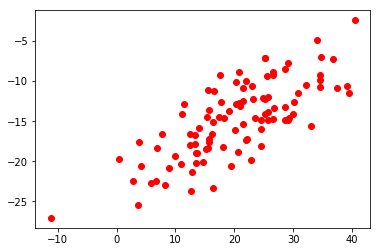

In [123]:
import numpy as np

X = [
    [20.9666776351559,-13.1138080189357],
    [22.7719907680008,-19.8890894944696],
    [25.6687103160153,-11.9956004517219],
    [18.0019794950564,-18.1989191165133],
    [21.3967402102156,-10.8893126308196],
    [0.443696899177716,-19.7221132386308],
    [29.9198322142127,-14.0958668502427],
    [19.0805843080126,-13.7888747608312],
    [16.4685063521314,-11.2612927034291],
    [21.4597664701884,-12.4740034586705],
    [3.87655283720532,-17.575162461771],
    [34.5713920556787,-10.705185165378],
    [13.3732115747722,-16.7270274494424],
    [20.7281704141919,-8.81165591556553],
    [24.839851437942,-12.1240962157419],
    [20.3019544741252,-12.8725060780898],
    [21.9021426929599,-17.3225432396452],
    [23.2285885715486,-12.2676568419045],
    [28.5749111681851,-13.2616470619453],
    [29.2957424128701,-14.6299928678996],
    [15.2495527798625,-18.4649714274207],
    [26.5567257400476,-9.19794350561966],
    [30.1934232346361,-12.6272709845971],
    [36.8267446011057,-7.25409849336718],
    [32.157416823084,-10.4729534347553],
    [5.85964365291694,-22.6573731626132],
    [25.7426190674693,-14.8055803854566],
    [16.237602636139,-16.5920595763719],
    [14.7408608850568,-20.0537715298403],
    [6.85907008242544,-18.3965586884781],
    [26.5918329233128,-8.92664811750842],
    [-11.2216019958228,-27.0519081982856],
    [8.93593745011035,-20.8261235122575],
    [24.4481258671796,-18.0324012215159],
    [2.82048515404903,-22.4208457598703],
    [30.8803004755948,-11.455358009593],
    [15.4586738236098,-11.1242825084309],
    [28.5332537090494,-14.7898744423126],
    [40.4830293441052,-2.41946428697183],
    [15.7563759125684,-13.5771266003795],
    [19.3635588851727,-20.6224770470434],
    [13.4212840786467,-19.0238227375766],
    [7.77570680426702,-16.6385739839089],
    [21.4865983854408,-15.290799330002],
    [12.6392705930724,-23.6433305964301],
    [12.4746151388128,-17.9720169566614],
    [23.4572410437998,-14.602080545086],
    [13.6878189833565,-18.9687408182414],
    [15.4077465943441,-14.5352487124086],
    [20.3356581548895,-10.0883159703702],
    [20.7093833689359,-12.6939091236766],
    [11.1032293684441,-14.1383848928755],
    [17.5048321498308,-9.2338593361801],
    [16.3303688220188,-15.1054735529158],
    [26.6929062710726,-13.306030567991],
    [34.4985678099711,-9.86199941278607],
    [39.1374291499406,-10.5621430853401],
    [21.9088956482146,-9.95198845621849],
    [22.2367457578087,-17.2200123442707],
    [10.0032784145577,-19.3557700653426],
    [14.045833906665,-15.871937521131],
    [15.5640911917607,-18.3396956121887],
    [24.4771926581586,-14.8715313479137],
    [26.533415556629,-14.693883922494],
    [12.8722580202544,-21.2750596021509],
    [24.4768291376862,-15.9592080959207],
    [18.2230748567433,-14.6541444069985],
    [4.1902148367447,-20.6144032528762],
    [12.4332594022086,-16.6079789231489],
    [20.5483758651873,-18.8512560786321],
    [17.8180560451358,-12.5451990696752],
    [11.0071081078049,-20.3938092335862],
    [8.30560561422449,-22.9503944138682],
    [33.9857852657284,-4.8371294974382],
    [17.4376502239652,-14.5095976075022],
    [29.0379635148943,-14.8461553663227],
    [29.1344666599319,-7.70862921632672],
    [32.9730697624544,-15.5839178785654],
    [13.4211493998212,-20.150199857584],
    [11.380538260355,-12.8619410359766],
    [28.672631499186,-8.51866271785711],
    [16.4296061111902,-23.3326051279759],
    [25.7168371582585,-13.8899296143829],
    [13.3185154732595,-17.8959160024249],
    [3.60832478605376,-25.4023343597712],
    [39.5445949652652,-11.466377647931],
    [25.1693484426101,-12.2752652925707],
    [25.2884257196471,-7.06710309184533],
    [6.77665715793125,-22.3947299635571],
    [20.1844223778907,-16.0427471125407],
    [25.5506805272535,-9.33856532270204],
    [25.1495682602477,-7.17350567090738],
    [15.6978431006492,-17.5979197162642],
    [37.42780451491,-10.843637288504],
    [22.974620174842,-10.6171162611686],
    [34.6327117468934,-9.26182440487384],
    [34.7042513789061,-6.9630753351114],
    [15.6563953929008,-17.2196961218915],
    [25.2049825789225,-14.1592086208169]
]
np_X= np.array(X)
plt.plot( np_X[:,0], np_X[:,1],"ro")
plt.show()

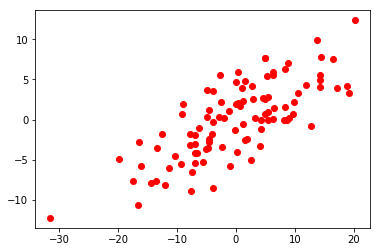

In [124]:
np_mean_X = np.array(de_mean_matrix(X))

plt.plot( np_mean_X[:,0], np_mean_X[:,1],"ro")
plt.show()

In [125]:
def make_matrix(num_rows,num_cols,entry_fn):
    return [[entry_fn(i,j) for j in range(num_cols)] for i in range(num_rows)]

In [126]:
def direction(w):
    mag = magnitude(w)
    return [w_i /mag for w_i in w]

In [127]:
def directional_variance_i(x_i,w):
    """w가 나타내는 방향에서 x_i행의 편차를 반환"""
    return dot(x_i, direction(w)) **2

def directional_variance(X,w):
    """w가 나타내는 방향에서 데이터 전체의 편차를 반환"""
    return sum(directional_variance_i(x_i,w)
              for x_i in X)

In [129]:
def directional_variance_gradient_i(x_i,w):
    """방향의 경사(w의 기울기)에 x_i행이 기여하는 부분"""
    projection_length = dot(x_i,direction(w))
    return [2 * projection_length* x_ij for x_ij in x_i]

def directional_variance_gradient(X,w):
    return vector_sum(directional_variance_gradient_i(x_i,w) for x_i in X)

In [136]:
from Chapter8_Gradient_Descent.ipynb import maximize_batch
def first_principal_component(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_batch(partial(directional_variance,X),
                                       partial(directional_variance_gradient,X),
                                       guess)
    return direction(unscaled_maximizer)

ModuleNotFoundError: No module named 'Chapter8_Gradient_Descent'

In [133]:
def first_principal_component(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_batch(
        partial(directional_variance, X),           # is now a function of w
        partial(directional_variance_gradient, X),  # is now a function of w
        guess)
    return direction(unscaled_maximizer)

def first_principal_component_sgd(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_stochastic(
        lambda x, _, w: directional_variance_i(x, w),
        lambda x, _, w: directional_variance_gradient_i(x, w),
        X, [None for _ in X], guess)
    return direction(unscaled_maximizer)

def project(v, w):
    """return the projection of v onto w"""
    coefficient = dot(v, w)
    return scalar_multiply(coefficient, w)

def remove_projection_from_vector(v, w):
    """projects v onto w and subtracts the result from v"""
    return vector_subtract(v, project(v, w))

def remove_projection(X, w):
    """for each row of X
    projects the row onto w, and subtracts the result from the row"""
    return [remove_projection_from_vector(x_i, w) for x_i in X]

def principal_component_analysis(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X)
        components.append(component)
        X = remove_projection(X, component)

    return components

def transform_vector(v, components):
    return [dot(v, w) for w in components]

def transform(X, components):
    return [transform_vector(x_i, components) for x_i in X]

print("PCA")

Y = de_mean_matrix(X)
components = principal_component_analysis(Y, 2)
print("principal components", components)
print("first point", Y[0])
print("first point transformed", transform_vector(Y[0], components))

PCA


NameError: name 'maximize_batch' is not defined